# Toy model for GP studies

## Alexandra Semposki

### Date: 02 September 2024

Here, we attempt to play with a simple toy model for a GP, with some amount of slow curvature, that should help illuminate our confusion with $\chi$EFT.

In [2]:
# import packages needed
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

sys.path.append('../src')

from gp_utils import GaussianProcessRegressor2dNoise

## 1. Set up the problem

First, let's design the curve that we want to test. We'll do this by plotting some points, randomized off of a true function that we have put into the `true_function` function below. 

In [3]:
def true_function(x):
    return -np.exp(0.2*x) * np.cos(0.8*x)

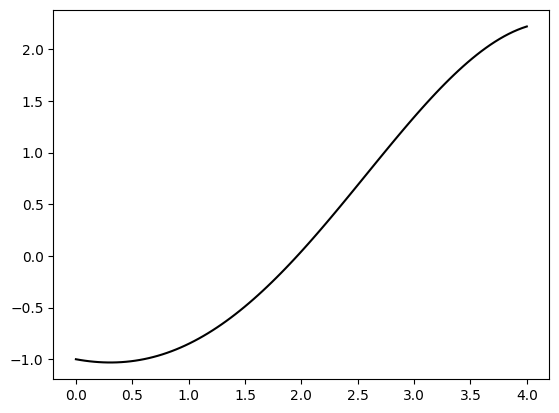

In [4]:
x = np.linspace(0.0, 4.0, 100)  # 6.0

plt.plot(x, true_function(x), 'k')

Now let's sample from this to get our dataset. We can do this by adding noise to the data that we grab, too, so it has some variation to it.

In [5]:
x_data = np.linspace(0.0,4.0,5) # 6.0
true_data = true_function(x_data)

# def random_func(x, dy=0.1):
#     return np.random.normal(true_function(x), dy)

y_data = true_function(x_data)#, dy=0.15)

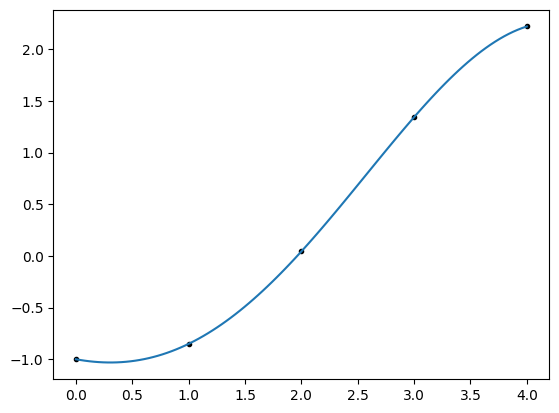

In [6]:
plt.plot(x_data, y_data, 'k.')
plt.plot(x, true_function(x))

Now we can simply take the result of the above plot and add some error bars to it, to symbolize errors.

In [7]:
np.random.seed(0)
y_err = np.diag(np.random.random(len(x_data)) * (0.35*np.eye(len(x_data))))

<ErrorbarContainer object of 3 artists>

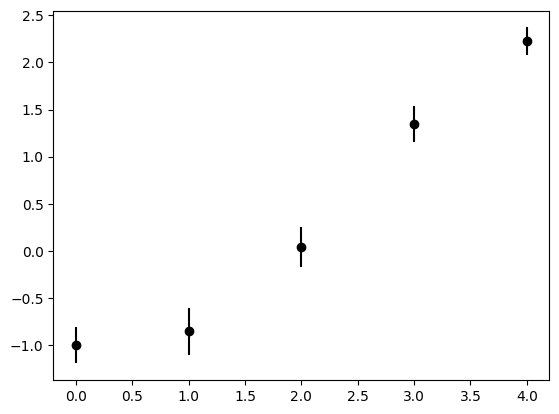

In [8]:
plt.plot(x_data, y_data, 'k.')
plt.errorbar(x_data, y_data, y_err, color='black', fmt='o')

## Adding a Gaussian process

Now we fit with a Gaussian process to get the curve, and then we'll try to get that same curve back using another GP, to see how things change.

1.59**2 * RBF(length_scale=2.18)


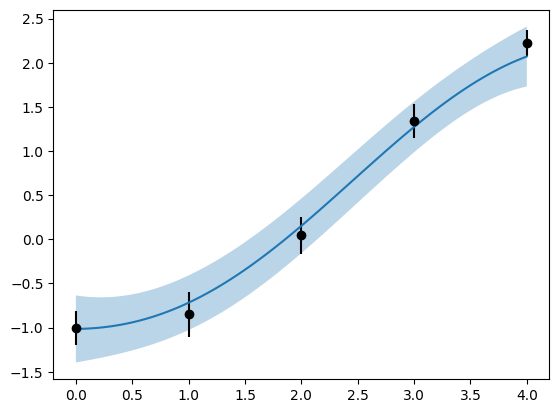

In [9]:
# calling sklearn 
kernel1 = ConstantKernel(1.0) * RBF(length_scale=1.0)
gp = GaussianProcessRegressor(
    kernel = kernel1,
    alpha = y_err,
)

x_train = x_data.reshape(-1,1)
y_train = y_data.reshape(-1,1)

# fit the GP using the training data
gp.fit(x_train, y_train) 

# show the kernel parameters
print(gp.kernel_)

# predict using this GP on new prediction data
y_predict, y_std = gp.predict(x.reshape(-1,1), return_std=True)
_, y_cov = gp.predict(x.reshape(-1,1), return_cov=True)

# now plot the results
plt.errorbar(x_data, y_data, y_err, fmt='o', color='k')
plt.plot(x, y_predict)
plt.fill_between(x, y_predict-y_std, y_predict+y_std, alpha=0.3)
plt.show()

## Fitting this with another GP

Now we'd like to see a GP that is able to recover this error band and general shape. We'll need data points from this GP, to try this out.

(100, 100)


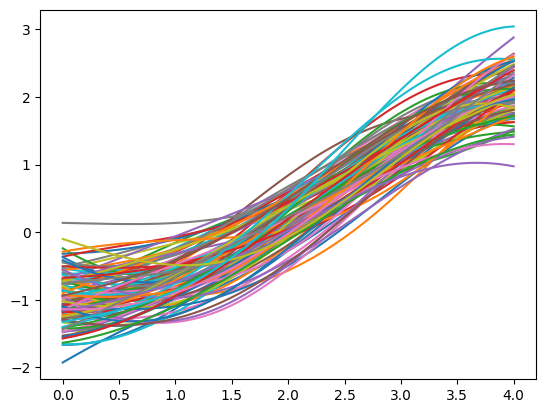

In [10]:
# getting points from this GP
samples = gp.sample_y(x.reshape(-1,1), 100)
print(samples.shape)
plt.plot(x, samples)
plt.show()

First, let's just take some data from the GP, using the mean and the covariance matrix. This will tell us if we cannot recover the mean easily using data from along it or not.

In [22]:
# pull training data from the GP's prediction set (the only access to direct values we have)
x_tr4 = x[25::15]
y_tr4 = y_predict[25::15]
y_trstd4 = y_std[25::15]
y_trcov4 = y_cov[25::15, 25::15]

# optional (chicken) nugget for regularization of Cholesky Decomposition
nugget = 1e-08*np.eye(len(x_tr4))

1.59**2 * RBF(length_scale=2.7)


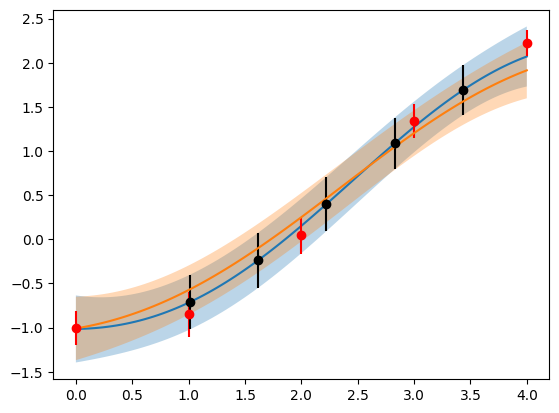

In [25]:
# train a new GP on this data and compare to the original
kernel2 = ConstantKernel(1.59**2.0) * \
RBF(length_scale=2.18)
gp2 = GaussianProcessRegressor2dNoise(
    kernel = kernel2,
    alpha = y_trcov4 + nugget,
)

gp2.fit(x_tr4.reshape(-1,1), y_tr4.reshape(-1,1), priors=False)

print(gp2.kernel_)

# predict at the same ol' array (no reason not to for now)
y_pred4, y_std4 = gp2.predict(x.reshape(-1,1), return_std = True)
_, y_cov4 = gp2.predict(x.reshape(-1,1), return_cov = True)

# plot the result over the original GP
plt.plot(x, y_predict)
plt.errorbar(x_data, y_data, y_err, fmt='o', color='r')
plt.fill_between(x, y_predict-y_std, y_predict+y_std, alpha=0.3)
plt.errorbar(x_tr4, y_tr4, y_trstd4, fmt='o', color='k')
plt.plot(x, y_pred4)
plt.fill_between(x, y_pred4-y_std4, y_pred4+y_std4, alpha=0.3)
plt.show()

In [26]:
# now let's check the width differences in the above error bands
width_true = (y_predict+y_std) - (y_predict-y_std)
width_7 = (y_pred4+y_std4) - (y_pred4-y_std4)

print('Relative error:\n', (np.abs((width_7 - width_true))/width_true)*100)
print('\nMaximum error difference: ', np.max((np.abs((width_7 - width_true))/width_true)*100))

Relative error:
 [ 5.43661283  5.16936436  4.95066578  4.78381675  4.67127827  4.61454572
  4.61405496  4.66912997  4.77797741  4.93773016  5.14453781  5.3936985
  5.67982327  5.99702194  6.33909886  6.69974678  7.07272872  7.45203977
  7.83204307  8.207577    8.57403283  8.92740411  9.26431041  9.58199898
  9.87832855 10.15173906 10.4012114  10.62622051 10.82668462 11.00291315
 11.15555481 11.28554738 11.39406983 11.48249747 11.55236021 11.60530407
 11.64305577 11.66739019 11.68010059 11.68297121 11.67775205 11.66613567
 11.6497358  11.63006769 11.60852997 11.58638827 11.56476024 11.54460238
 11.52669839 11.51164942 11.49986604 11.49156224 11.48675135 11.48524412
 11.48664882 11.49037363 11.49563116 11.50144526 11.50666002 11.50995119
 11.50983984 11.50470855 11.49282006 11.47233878 11.44135515 11.39791331
 11.34004231 11.26579144 11.17326981 11.06069108 10.92642327 10.76904442
 10.58740391 10.38068963 10.14850017  9.89092124  9.60860429  9.30284486
  8.97565682  8.62983775  8.2690196

OK, now let's see what happens if we instead use many more points than 7. Let's try using 25 of the total 100 in the original set.

In [27]:
# pull training data from the GP's prediction set (the only access to direct values we have)
x_tr50 = x[5::11]
y_tr50 = y_predict[5::11]
y_trstd50 = y_std[5::11]
y_trcov50 = y_cov[5::11, 5::11]

# optional (chicken) nugget for regularization of Cholesky Decomposition
nugget50 = 1e-08*np.eye(len(x_tr50))

0.47**2 * RBF(length_scale=9.67e+04)


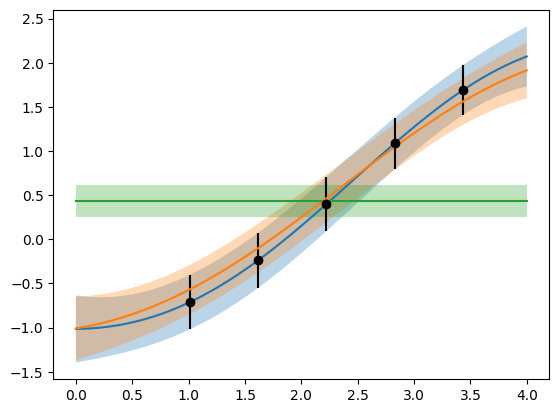

In [28]:
# train a new GP on this data and compare to the original
gp3 = GaussianProcessRegressor2dNoise(
    kernel = kernel1,
    alpha = y_trcov50 + nugget50,
)

gp3.fit(x_tr50.reshape(-1,1), y_tr50.reshape(-1,1), priors=False)

print(gp3.kernel_)

# predict at the same ol' array (no reason not to for now)
y_pred50, y_std50 = gp3.predict(x.reshape(-1,1), return_std = True)
_, y_cov50 = gp3.predict(x.reshape(-1,1), return_cov = True)

# plot the result over the original GP
plt.plot(x, y_predict)
plt.fill_between(x, y_predict-y_std, y_predict+y_std, alpha=0.3)
plt.errorbar(x_tr4, y_tr4, y_trstd4, fmt='o', color='k')
plt.plot(x, y_pred4)
plt.fill_between(x, y_pred4-y_std4, y_pred4+y_std4, alpha=0.3)
plt.plot(x, y_pred50)
plt.fill_between(x, y_pred50-y_std50, y_pred50+y_std50, alpha=0.3)
plt.show()

In [16]:
# now let's check the width differences in the above error bands
width_true = (y_predict+y_std) - (y_predict-y_std)
width_25 = (y_pred50+y_std50) - (y_pred50-y_std50)

print('Relative error:\n', (np.abs((width_25 - width_true))/width_true)*100)
print('\nMaximum error difference: ', np.max((np.abs((width_25 - width_true))/width_true)*100))

Relative error:
 [52.98002149 51.96569899 50.98149661 50.03367104 49.12816872 48.27045297
 47.46533998 46.7168538  46.02810945 45.40123172 44.83731422 44.33642057
 43.89762581 43.51909388 43.19818403 42.93157822 42.71542053 42.54546033
 42.41719163 42.32598275 42.26719179 42.23626549 42.22881994 42.24070357
 42.26804306 42.30727416 42.35515908 42.40879283 42.46560059 42.52332799
 42.58002614 42.63403298 42.68395205 42.72862983 42.76713247 42.79872235
 42.82283508 42.8390572  42.84710477 42.84680306 42.83806735 42.82088506
 42.79529897 42.76139186 42.71927245 42.66906256 42.61088579 42.54485754
 42.47107645 42.38961746 42.30052631 42.20381577 42.09946355 41.98741188
 41.86756908 41.73981284 41.60399556 41.45995172 41.30750722 41.14649104
 40.97674899 40.79815989 40.61065414 40.41423475 40.20900109 39.99517525
 39.77313119 39.5434267  39.30683808 39.06439738 38.81743189 38.56760544
 38.31696055 38.06796032 37.82352863 37.58708613 37.36257976 37.15450209
 36.96789671 36.80834513 36.681930